# Examples of using `pylabeladjust`
First we do some imports...

In [31]:
# !conda create -n pylabeladjust_development_env python=3.8
# !conda activate pylabeladjust_development_env


In [32]:
# !conda install pandas numpy matplotlib
# !conda install tqdm imageio
# !pip install opinionated

In [33]:
# Import standards:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm.notebook import tqdm
import shutil
import imageio
from IPython.display import Image, display



import textwrap # it wraps text! :)


# Import opinionated for nicer plots:
import opinionated
plt.style.use("opinionated_rc")
import colormaps as cmaps 

# Autoreload, for development:
%load_ext autoreload
%autoreload 2


# Import the pylabeladjust-functions:
from pylabeladjust import adjust_labels,adjust_texts,plot_rectangles




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example 1: adjust Texts
To show how pylabeladjust works, we load some sample-data from a recent project of mine:

In [34]:
data = pd.read_csv("data/EPSA23_example.csv")
display(data)

Unnamed: 0         x         y  \
0             0  5.606269  7.490148   
1             1  5.617779  3.731517   
2             2  5.327194  6.771035   
3             3  5.788806  9.482959   
4             4  5.689692  9.656334   
..          ...       ...       ...   
190         190  4.746625  2.385326   
191         191  5.259864  3.196076   
192         192  6.902723  4.990467   
193         193  6.407291  3.812750   
194         194  4.290433  5.820129   

                                                 title  fontsize fontweight  
0                                On probability theory       5.1       bold  
1                  The Nature of Research Environments       5.7       bold  
2              Modalities In Scientific Representation       5.7       bold  
3    A Categoricity Problem For Quantum Inferentialism       4.2     normal  
4    Perspectivist Account of Truth-Theoretic Seman...       4.2     normal  
..                                                 ...       ...        ...  
190   Discrimination, Measurement and Normative Theory       5.7       bold  
191                                     Loving Science       4.2     normal  
192  Literature Navigation Systems: An Epistemologi...       4.2     normal  
193                      What Makes Research Relevant?       4.2     normal  
194  Causation and Causal Models—how To Overcome Th...       5.7       bold  

[195 rows x 6 columns]

Here's what that data would look like plotted directly. We notice unightly overlaps.

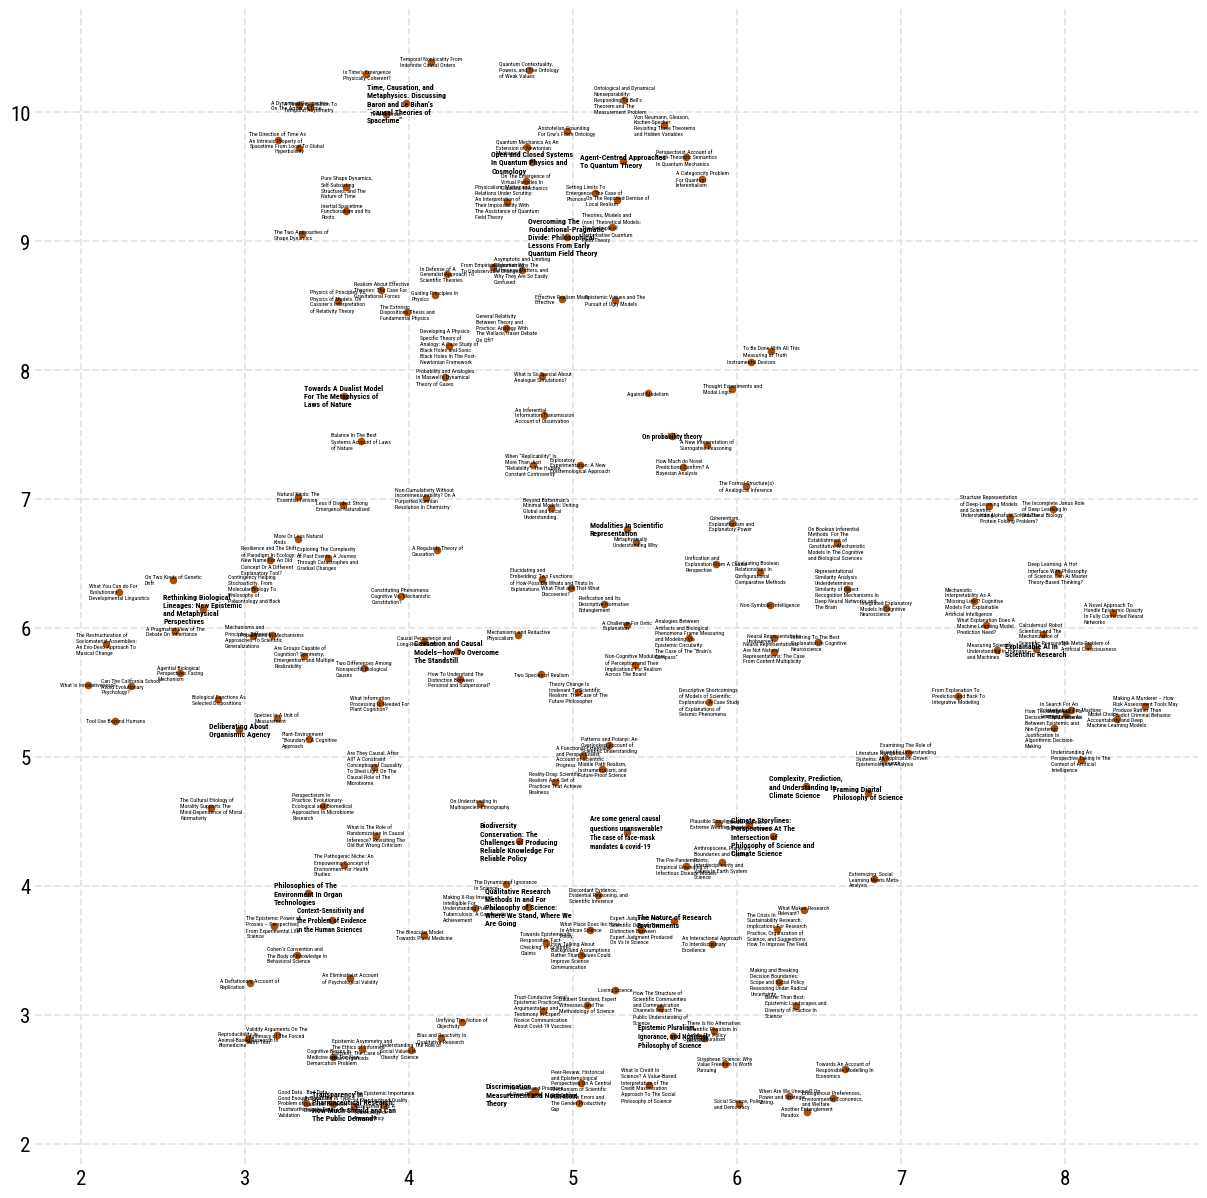

In [35]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(data['x'], data['y'], s=20, alpha=1., c='#a7510f')
texts = []
for i, row in data.iterrows():
    texts.append(ax.text(row['x'], row['y'], textwrap.fill(row['title'],25) , fontsize=row['fontsize'],fontweight=row['fontweight'],zorder=10,
                         ha='center',va='center', 
                         ma='left'))


Now, let's apply `adjust_texts`:

  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment


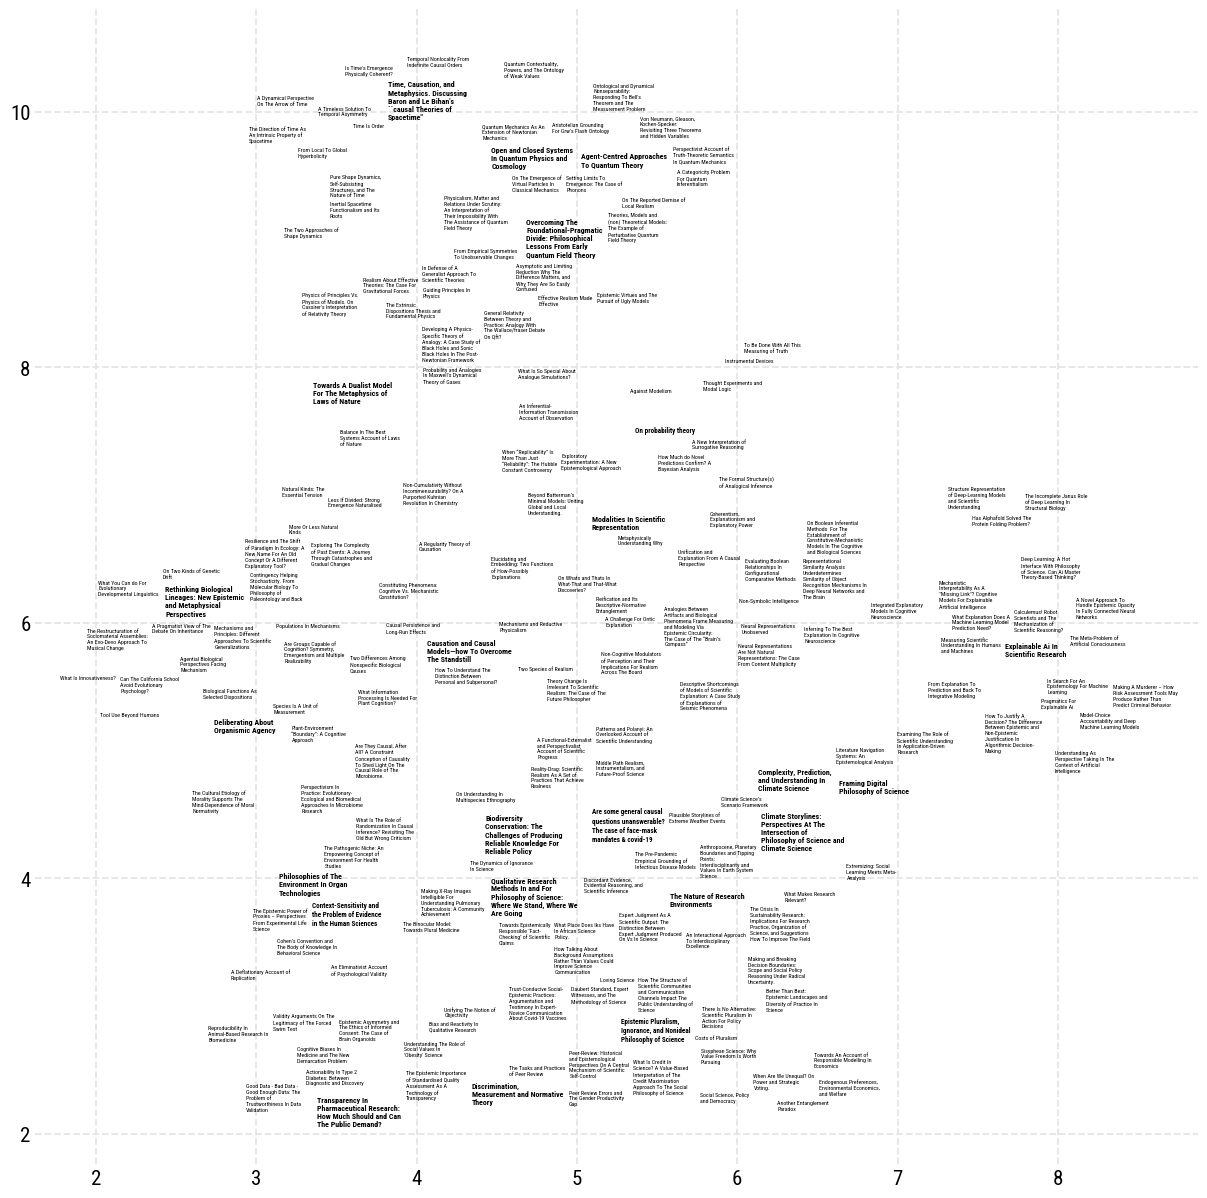

In [36]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(data['x'], data['y'], s=20, alpha=0.0, c='#a7510f')

texts = []
for i, row in data.iterrows():
    texts.append(ax.text(row['x'], row['y'], textwrap.fill(row['title'],25) , fontsize=row['fontsize'],fontweight=row['fontweight'],zorder=10,
                        ha='center',va='center', 
                         ma='left'))
fig.canvas.draw()

rectangles_adjusted, optimization_progress_texts = adjust_texts(texts,speed=.03,max_iterations=500, adjust_by_size=True, 
                                                                margin=4.5,radius_scale=1.03, return_optimization_process=True)

ax.scatter(rectangles_adjusted['x'], rectangles_adjusted['y'], s=20, alpha=0.0, c='#d6b4fc')

# Save the figure with good DPI
plt.savefig('images/text_adjustment_result.png', dpi=300)
plt.show()



Much more readable, I think! Note, btw. how using a narrow font lets us get away with only few adjustments. A good diagnostic to see whether your layout is close enough to what you expect is to link the original and the new points with arrows. I think the example below is quite satisfying, with only a few texts considerably moved.

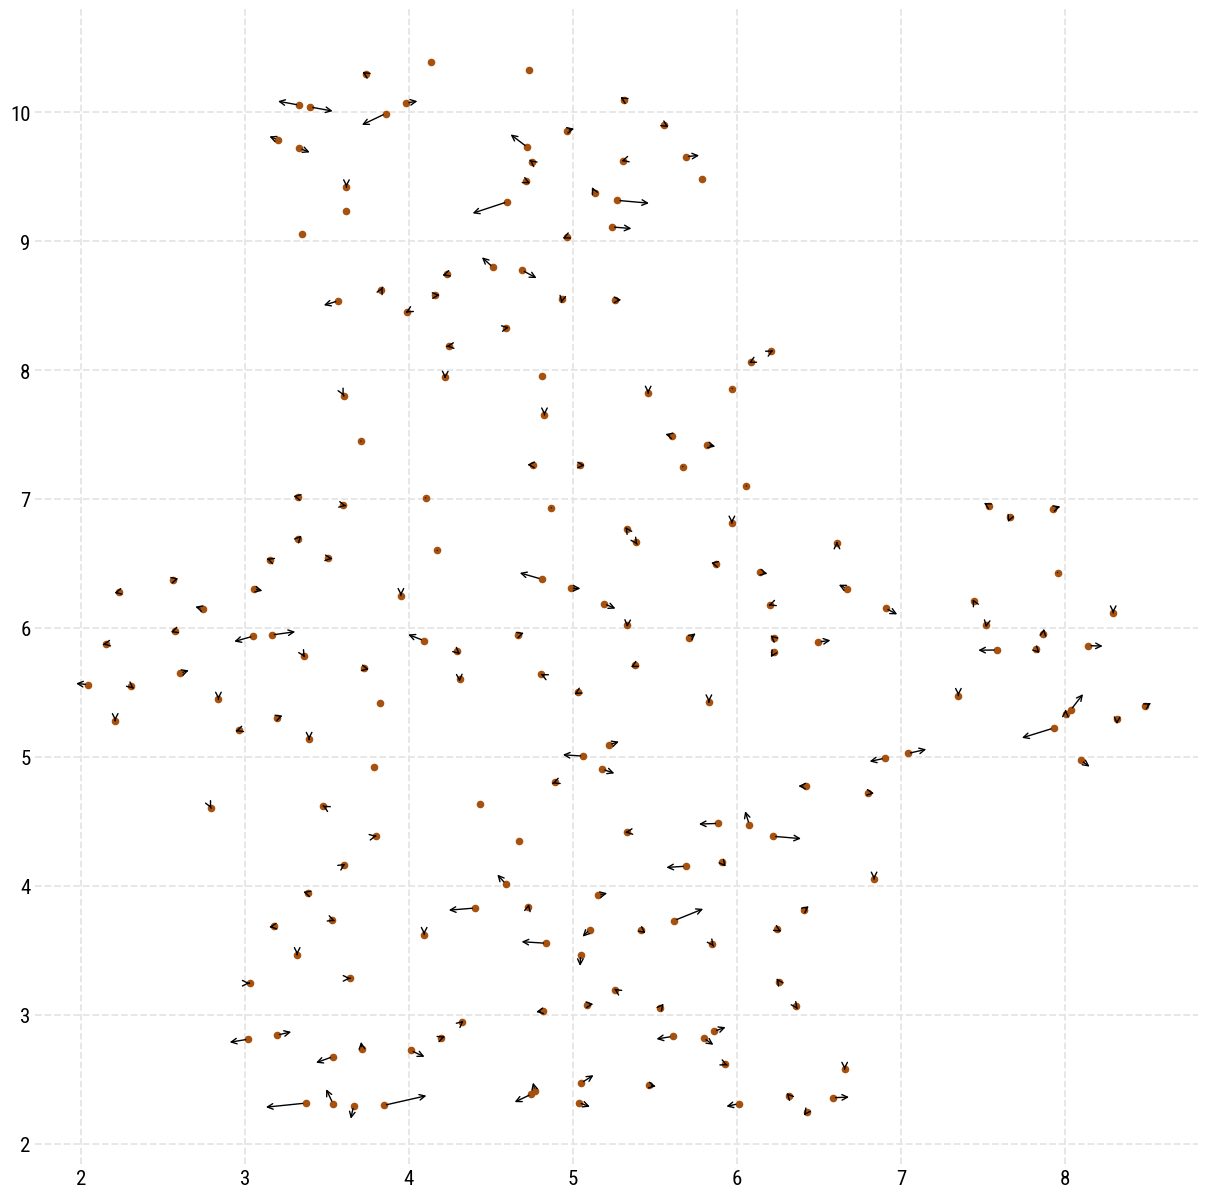

In [7]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(data['x'], data['y'], s=20, alpha=1., c='#a7510f')
for i in range(len(data)):
    ax.annotate("", xy=(rectangles_adjusted.loc[i, 'x'], rectangles_adjusted.loc[i, 'y']), xytext=(data.loc[i, 'x'], data.loc[i, 'y']),
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

plt.show()

We can also plot an overlay:

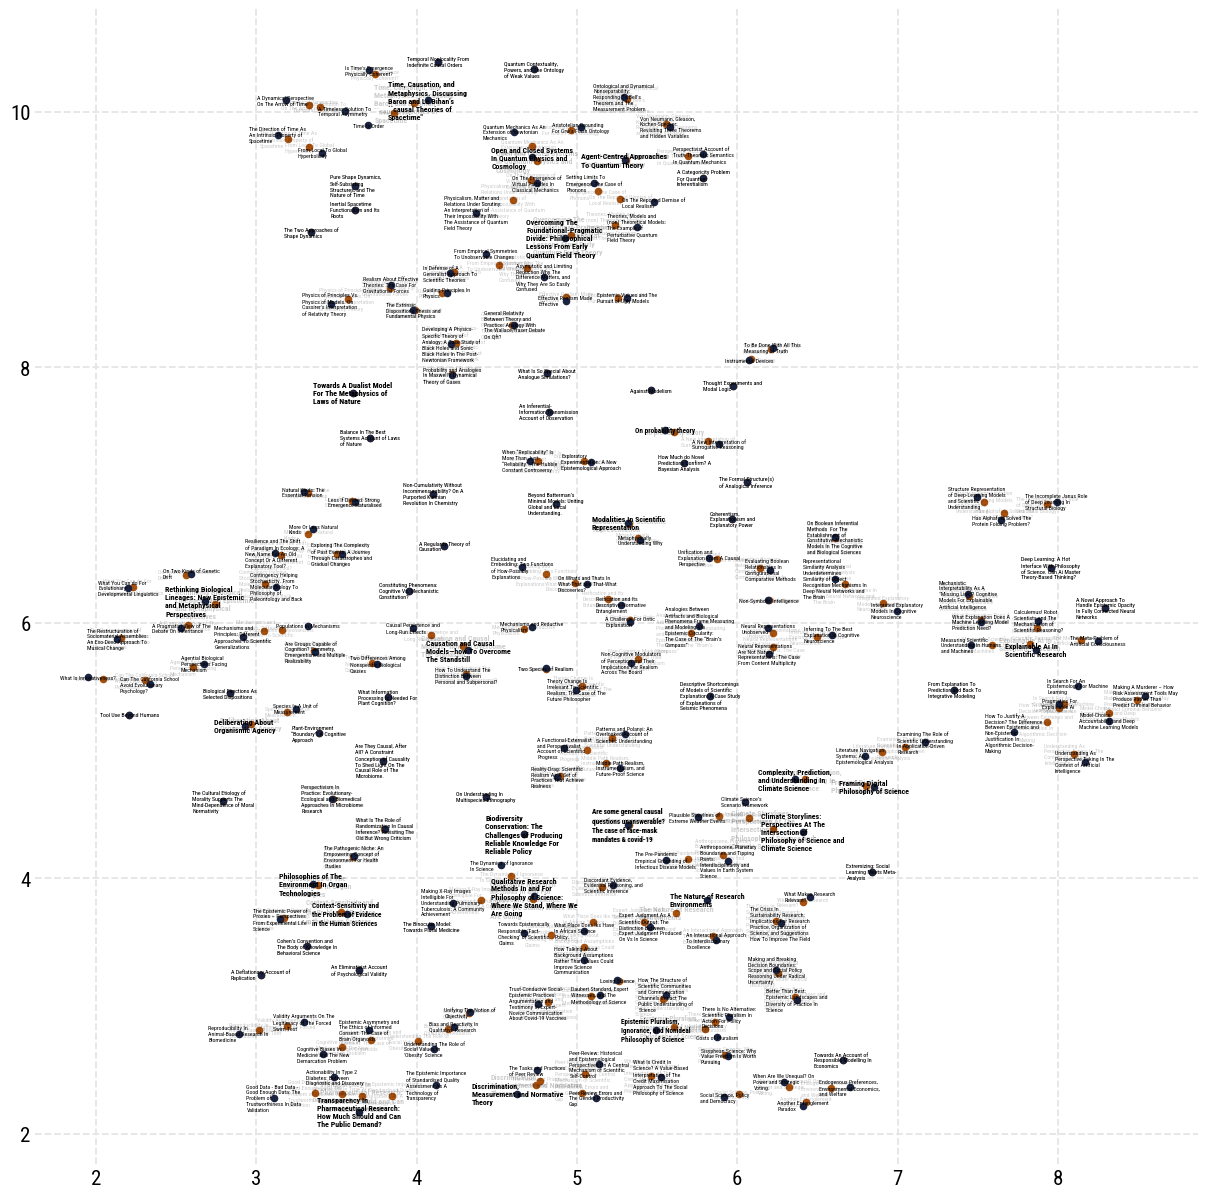

In [8]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(data['x'], data['y'], s=20, alpha=1.0, c='#a7510f')
texts = []
for i, row in data.iterrows():
    texts.append(ax.text(row['x'], row['y'], textwrap.fill(row['title'],25) , fontsize=row['fontsize'],fontweight=row['fontweight'],zorder=10,alpha=.2,
                         ha='center',va='center',ma='left'))
    
ax.scatter(rectangles_adjusted['x'], rectangles_adjusted['y'], s=20, alpha=1., c='#1a2340')

    
for i, row in rectangles_adjusted.iterrows():
    texts.append(ax.text(row['x'], row['y'], textwrap.fill(data.iloc[i]['title'],25) , fontsize=data.iloc[i]['fontsize'],
                         ma='left',fontweight=data.iloc[i]['fontweight'],zorder=12,ha='center',va='center'))
    

Finally we can save the adjustment progress as a .gif.

In [9]:
from PIL import Image as IMG


def plot_texts(ax, text_data,coordinates):
    ax.scatter(coordinates['x'], coordinates['y'], s=20, alpha=0, c='#a7510f')
    texts = []
    for i, row in text_data.iterrows():
        texts.append(ax.text(coordinates['x'][i], coordinates['y'][i], textwrap.fill(row['title'], 25),
                             fontsize=row['fontsize'], ha='center',va='center', ma='left', fontweight=row['fontweight'], zorder=10))

def plot_texts_to_gif(text_data,data_list, n, output_filename):
    temp_dir = 'images/temp'
    os.makedirs(temp_dir, exist_ok=True)  # Create the temporary directory
    
    selected_indices = np.linspace(0, len(data_list) - 1, n, dtype=int)
    images = []

    for i in tqdm(selected_indices):
        fig, ax = plt.subplots(figsize=(15,15))
        plot_texts(ax, text_data,data_list[i])
        # ax.axis('off')
        ax.set_xlim([data_list[i]['x'].min() - .1, data_list[i]['x'].max() + .1])
        ax.set_ylim([data_list[i]['y'].min() - .1, data_list[i]['y'].max() + .1])
        plt.tight_layout()
        
        img_path = os.path.join(temp_dir, f'temp_{i}.png')
        plt.savefig(img_path,dpi=90)
        plt.close(fig)
        
        images.append(imageio.imread(img_path))
        #images.append(IMG.open(img_path))

    # Create GIF
    imageio.mimsave(output_filename, images, duration=9, loop=0)

    #images[0].save(output_filename, save_all=True, append_images=images[1:], optimize=False, duration=80, loop=0)

    
    # Clean up: delete the temporary directory and its contents
    shutil.rmtree(temp_dir)

# Example usage
# data_list = [Your list of dataframes each with 'x', 'y', 'title', 'fontsize', 'fontweight' columns]
plot_texts_to_gif(data,optimization_progress_texts + [rectangles_adjusted],n=90, output_filename='images/layout_process_texts.gif')


  0%|          | 0/90 [00:00<?, ?it/s]

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_32001/3546360177.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_path))


I'll also compress the gif, so it shows up on PyPI:

In [10]:
import subprocess
import os

def optimize_gif_to_target_size(input_path, output_path, max_file_size, initial_colors=256, optimization_level=3):
    """
    Optimize a GIF file to be under a specific file size.
    
    Args:
    input_path (str): Path to the input GIF file.
    output_path (str): Path to the output optimized GIF file.
    max_file_size (int): Maximum file size in bytes.
    initial_colors (int): Starting number of colors.
    optimization_level (int): Level of optimization by gifsicle.
    """
    colors = initial_colors
    step = max(16, colors // 8)  # Reduce colors in steps, minimum step is 16

    while True:
        # Build the gifsicle command
        command = [
            'gifsicle',
            '-O{}'.format(optimization_level),
            '--colors', str(colors),
            input_path,
            '-o', output_path
        ]
        
        # Execute the command
        subprocess.run(command, check=True)
        file_size = os.path.getsize(output_path)

        print(f"Trying {colors} colors: Output file size is {file_size} bytes")

        # Check if the file size is within the desired limit
        if file_size <= max_file_size:
            print("GIF optimized to target size.")
            break
        elif colors <= 16:
            print("Reached minimum color threshold with no success.")
            break
        else:
            # Decrease the number of colors and try again
            colors -= step
            if colors < 16:
                colors = 16  # Ensure minimum colors is not below 16


optimize_gif_to_target_size('images/layout_process_texts.gif', 'images/layout_process_texts.gif', max_file_size = 4.95 * 1024 * 1024 )


gifsicle: warning: trivial adaptive palette (only 17 colors in source)


Trying 256 colors: Output file size is 2980518 bytes
GIF optimized to target size.


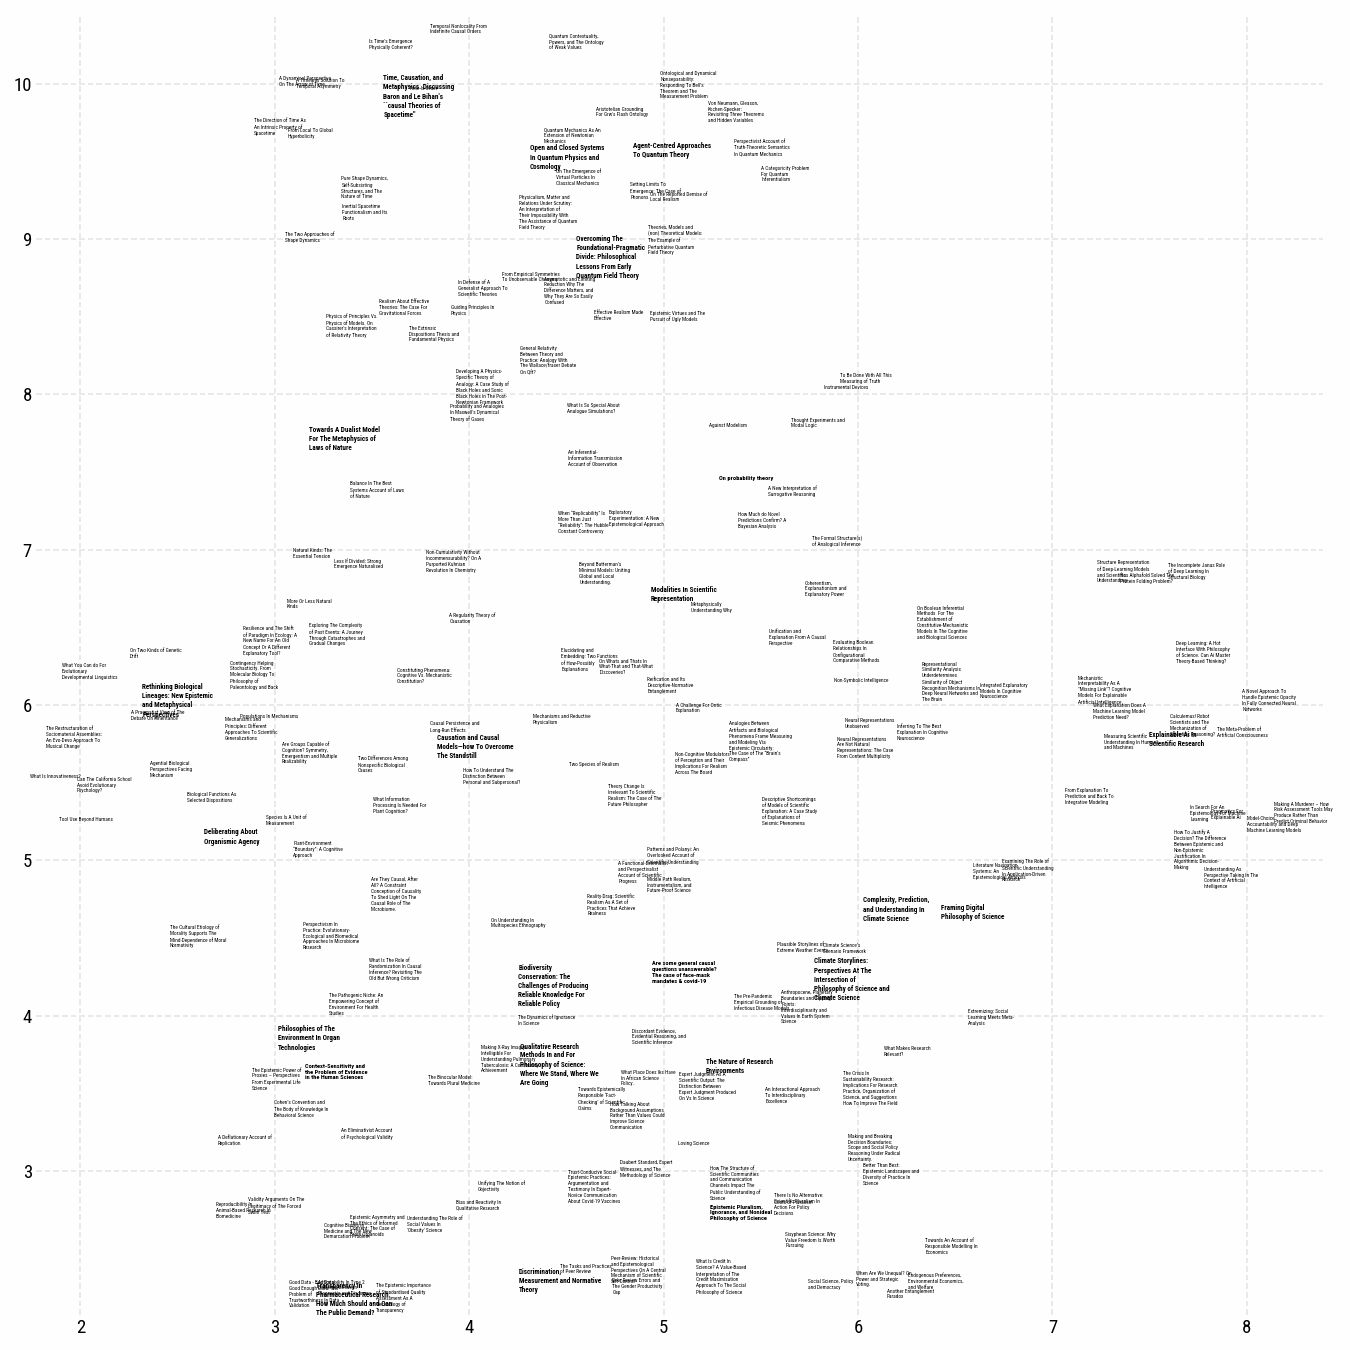

In [11]:
display(Image(filename='images/layout_process_texts.gif'))


# Example2: Adjust rectangles directly
This time we load some example data of images layed out with UMAP. (Were going to visualize them with vikus-viewer later...)

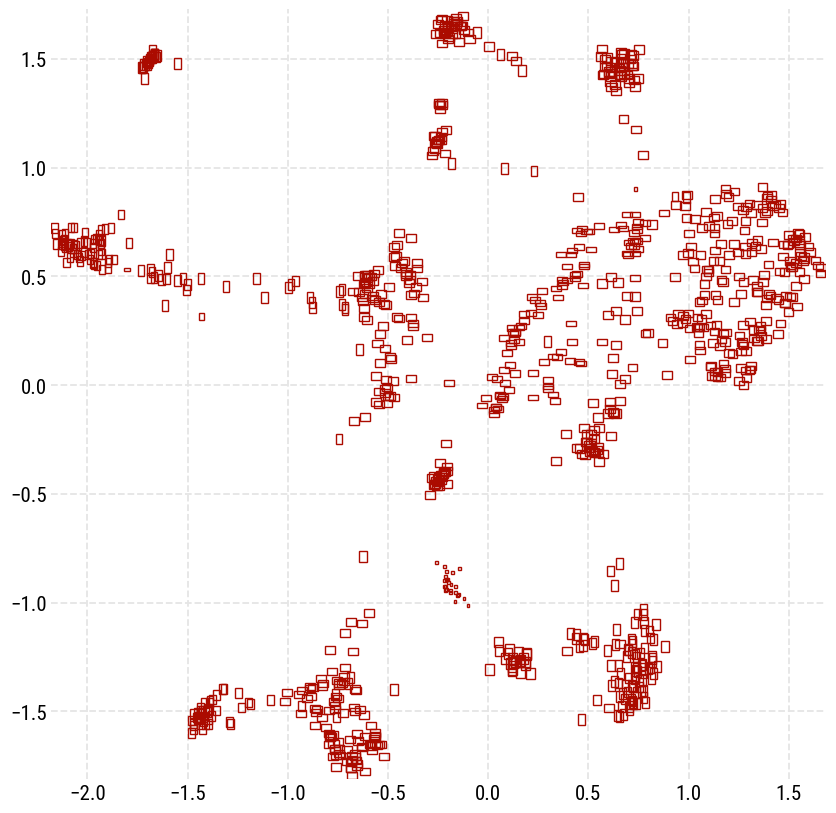

In [12]:
data = pd.read_csv("data/vsz_image_map.csv")


fig, ax = plt.subplots(figsize=(10,10))
plot_rectangles(ax,data,color= '#ab0b00')
plt.show()

Now we run the adjustmnet algorithm on the rectangles data directly: 

In [25]:
rectangles_adjusted, optimization_process = adjust_labels(data,
                                  
                                  speed=.01,
                                    adjust_by_size=True,
                                    radius_scale=1.01,
                                    max_iterations=250,
                                    margin=4.5,
                                    margin_type='percentage',
                                    return_optimization_process=True)


  0%|          | 0/250 [00:00<?, ?it/s]

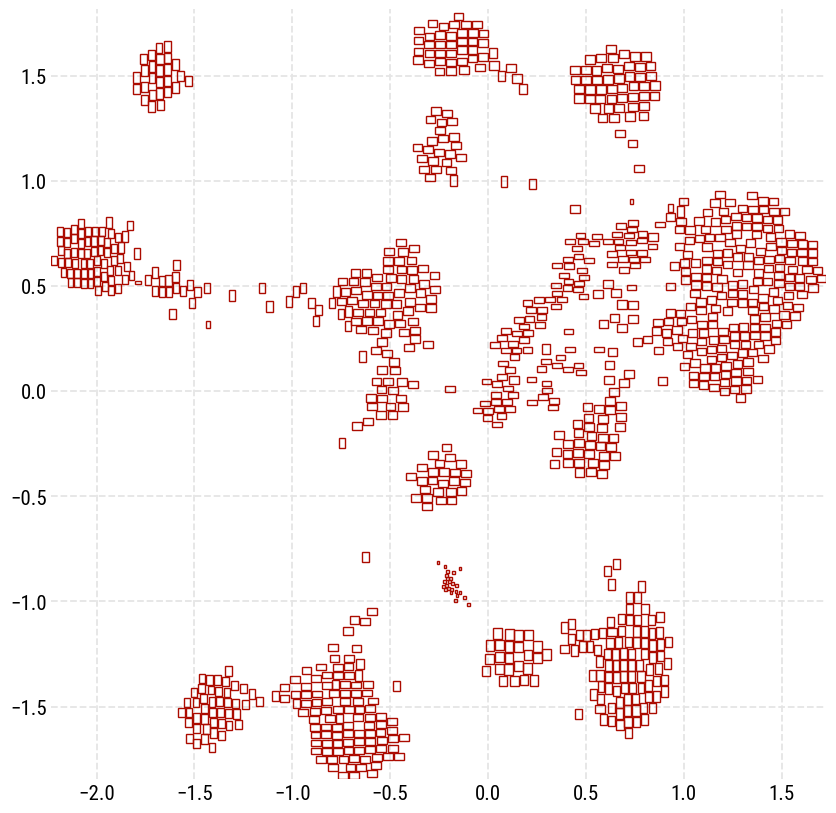

In [26]:


fig, ax = plt.subplots(figsize=(10,10))
plot_rectangles(ax,rectangles_adjusted,color= '#ab0b00')
plt.show()

In [27]:
import imageio

def plot_rectangles_to_gif(rectangles_adjusted_list, n, output_filename):
    temp_dir = 'images/temp'
    os.makedirs(temp_dir, exist_ok=True)  # Create the temporary directory
    
    selected_indices = np.linspace(0, len(rectangles_adjusted_list) - 1, n, dtype=int)
    images = []

    for i in tqdm(selected_indices):
        fig, ax = plt.subplots(figsize=(10,10))
        plot_rectangles(ax, rectangles_adjusted_list[i],color= '#ab0b00')
        # plt.axis('off')
        plt.tight_layout()
        ax.set_xlim([rectangles_adjusted_list[i]['x'].min() - .3, rectangles_adjusted_list[i]['x'].max() + .3])
        ax.set_ylim([rectangles_adjusted_list[i]['y'].min() - .3, rectangles_adjusted_list[i]['y'].max() + .3])
        img_path = os.path.join(temp_dir, f'temp_{i}.png')  # Use os.path.join for path construction
        plt.savefig(img_path)
        plt.close(fig)
        
        images.append(imageio.imread(img_path))

    # Create GIF
    imageio.mimsave(output_filename, images, duration=14, loop=0)
    
    # Clean up: delete the temporary directory and its contents
    shutil.rmtree(temp_dir)


# Example usage
plot_rectangles_to_gif(optimization_process+[rectangles_adjusted], n=100, output_filename='images/layout_process_rectangles.gif')
optimize_gif_to_target_size('images/layout_process_rectangles.gif', 'images/layout_process_rectangles.gif', max_file_size = 4.95 * 1024 * 1024 )


  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_32001/2444371926.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_path))
gifsicle: warning: trivial adaptive palette (only 195 colors in source)


Trying 256 colors: Output file size is 1607285 bytes
GIF optimized to target size.


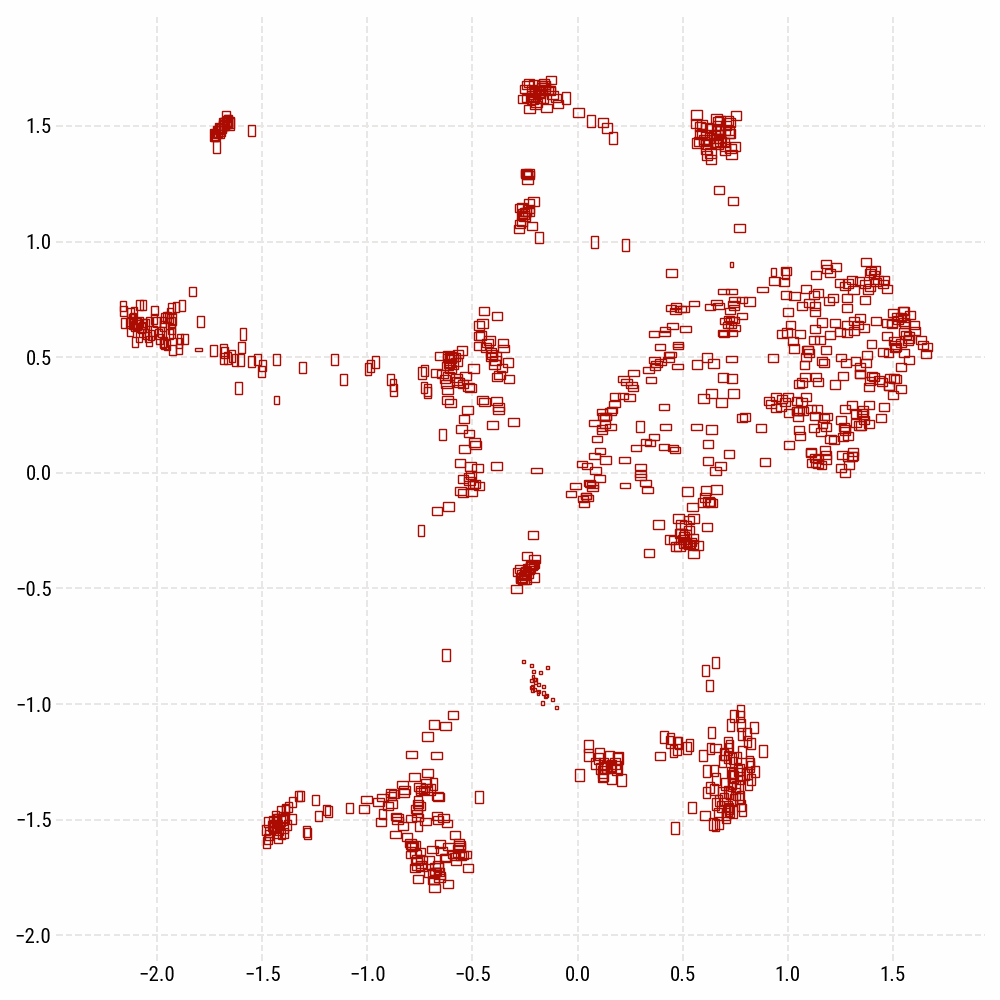

In [29]:

display(Image(filename='images/layout_process_rectangles.gif'))
